# Project UTS - Pengolahan Bahasa Alami
##  KLASIFIKASI TEKS BAHASA INDONESIA UNTUK BERITA OLAHRAGA

**Anggota Kelompok:**
1. Emmanuel Mathew Krisna Rata - 200710530
2. Antonius Indra Wardhana - 200710542
3. Farrel Rayner Nathanael Geovano - 200710560
4. Edmond Sorensen - 200710617
4. Paulus Bayu Kurnia Wicaksono - 200710691

## Objective
Mempermudah pembaca dalam menemukan berita yang dituju 

Meningkatkan efisiensi dan efektivitas dalam mengelola berita 

## Latar Belakang
POIN 1 

Klasifikasi berita olahraga juga dapat membantu pembaca untuk menemukan berita yang lebih relevan dengan minatnya. Hal ini karena berita-berita olahraga yang dikategorikan akan lebih mudah dicari dan diakses. 

POIN 2 

Klasifikasi berita olahraga dapat membantu media massa untuk mengelola berita olahraga dengan lebih efisien dan efektif. Hal ini dapat dilakukan dengan memisahkan berita-berita olahraga berdasarkan kategorinya masing-masing 

## Deskripsi Dataset
SUMBER 

Sumber berita online terkait olahraga diambil dari CNN 

KARAKTERISTIK 

Label yang dipakai adalah Judul berita, kategori berita. Jumlah data ada pada dataset adalah 2000 baris 

## Pengembangan Model Klasifikasi Teks


### Inisialisasi
Silakan isi bagian ini dengan mengimport library-library yang akan digunakan. 

In [36]:
import numpy as np
import pandas as pd
import modSpellChecker as sc
from contractions_id import CONTRACTION_MAP
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import gensim
from gensim.models import Word2Vec
from gensim import models
#from pattern.en import tag
from nltk.corpus import wordnet as wn
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from gensim import corpora, models
import sklearn
#from normalization import normalize_corpus
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from datetime import datetime
import csv
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Data Preparation
Silakan isi bagian ini dengan script untuk memanggil data yang akan digunakan untuk keperluan pengembangan model klasifikasi teks dan menampilkan contoh data yang telah dipanggil baik yang akan dijadikan sebagai input maupun target-nya (label).

In [2]:
dataset = pd.read_csv('cnn_sport.csv')
dataset

,title,category,link
0,Klasemen Liga Inggris: Tottenham Gusur Man Cit...,Sepakbola,https://www.cnnindonesia.com/olahraga/20231024...
1,Khamzat Disebut Tak Pantas Dapat Duel Gelar Ju...,Olahraga Lainnya,https://www.cnnindonesia.com/olahraga/20231023...
2,"Hasil Liga Inggris: Son Cetak Gol, Tottenham H...",Sepakbola,https://www.cnnindonesia.com/olahraga/20231024...
3,Binder Merasa Kasihan Martin Gagal Menang di M...,Moto GP,https://www.cnnindonesia.com/olahraga/20231024...
4,FOTO: Tottenham Jaga Rekor Belum Terkalahkan U...,Sepakbola,https://www.cnnindonesia.com/olahraga/20231024...
...,...,...,...
1995,Jadwal Siaran Langsung Final Hong Kong Open: 3...,Raket,https://www.cnnindonesia.com/olahraga/20230917...
1996,Klasemen Liga Inggris Usai MU Terpuruk di Old ...,Sepakbola,https://www.cnnindonesia.com/olahraga/20230917...
1997,Ronaldo Tunjukkan Gairah Besar di Saudi Pro Le...,Sepakbola,https://www.cnnindonesia.com/olahraga/20230917...
1998,"2 Pemain Al Raed Berebut Tendang Penalti, Rona...",Sepakbola,https://www.cnnindonesia.com/olahraga/20230917...


In [3]:
kategori_tidak_ingin_dihapus = ['Category not found','Analisis','Tanya Jawab','Infografis']

dataset = dataset[~dataset['category'].isin(kategori_tidak_ingin_dihapus)]

In [4]:
dataset.shape

(1973, 3)

In [5]:
df2 = dataset.groupby(['category'])['title'].count()
df2

category
F1                    7
Moto GP             357
Olahraga Lainnya    394
Raket               219
Sepakbola           996
Name: title, dtype: int64

In [6]:
label = dataset.iloc[:,1]
feature = dataset.iloc[:,0]

In [7]:
label[0:10]

0            Sepakbola
1     Olahraga Lainnya
2            Sepakbola
3              Moto GP
4            Sepakbola
6            Sepakbola
7            Sepakbola
8              Moto GP
9            Sepakbola
10               Raket
Name: category, dtype: object

In [8]:
feature[0:10]

0     Klasemen Liga Inggris: Tottenham Gusur Man Cit...
1     Khamzat Disebut Tak Pantas Dapat Duel Gelar Ju...
2     Hasil Liga Inggris: Son Cetak Gol, Tottenham H...
3     Binder Merasa Kasihan Martin Gagal Menang di M...
4     FOTO: Tottenham Jaga Rekor Belum Terkalahkan U...
6           Messi Banggakan Capaian Bersama Inter Miami
7     Erick Thohir Soal Persiapan Piala Dunia U-17: ...
8     Bagnaia Mulai Pongah Jelang MotoGP Thailand da...
9     Sidang Komdis PSSI: Hugo Samir Pukul Pemain Pe...
10          Daftar Pemain Indonesia di French Open 2023
Name: title, dtype: object

### Normalisasi Data
Silakan isi bagian ini dengan script untuk keperluan normalisasi data teks yang akan digunakan untuk pengembangan model klasifikasi teks. 
Untuk setiap strategi normalisasi yang akan digunakan sebaiknya dibuat fungsi tersendiri dan dipanggil dalam satu fungsi normalisasi. Jangan lupa pada bagian ini ditampilkan contoh hasil normalisasi datanya.

In [9]:
#fungsi2 untuk normalisasi dataset
character =['z','y','x','w','v','u','t','s','r','q','p','o','n','m','l','k','j','i','h','g','f','e','d','c','b','a',',','.',';',':','-','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@']
def repeatcharNormalize(text):
    for i in range(len(character)):
        charac_long = 5
        while charac_long>=2:
            char=character[i]*charac_long
            text=text.replace(char,character[i])
            charac_long-=1
        return text
def spellNormalize(text):
    spellCheck = []
    for i in text:
        if i not in character:
            j=sc.correction(i)
            spellCheck.append(j)
        else:
            spellCheck.append(i)
        return spellCheck
def tokenize_text(text):
    tokens=nltk.word_tokenize(text)
    tokens=[token.strip() for token in tokens]
    return tokens
def expand_contractions(text, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
    flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'","", expanded_text)
    return expanded_text
def stemmer_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    return text
# def lemmatize_text(text):
# pos_tagged_text = pos_tag_text(text)
# lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
# else word for word,
# pos_tag in pos_tagged_text]
# lemmatize_text=' '.join(lemmatized_tokens)
# return lemmatize_text

In [10]:
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('',token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
factory = StopWordRemoverFactory()
stopword_list = factory.get_stop_words()
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        text = stemmer_text(text)
        text = remove_special_characters(text)
        text = repeatcharNormalize(text)
        text = remove_stopwords(text)
        normalized_corpus.append(text)
        if tokenize:
            text = tokenize_text(text)
            text = spellNormalize(text)
            normalized_corpus.append(text)
    return normalized_corpus

### Ekstraksi Fitur
Silakan isi bagian ini dengan script untuk keperluan ekstraksi fitur data teks yang akan digunakan untuk pengembangan model klasifikasi teks. 
Untuk setiap strategi ekstraksi fitur yang akan digunakan sebaiknya dibuat fungsi tersendiri dan dipanggil dalam satu fungsi ekstraksi fitur. Jangan lupa pada bagian ini ditampilkan contoh hasil ekstraksi fitur terhadap datanya.

In [11]:
#Fungsi untuk mengekstraksi feature menggunakan TF-IDF Model
def tfidf_transformer(bow_matrix):
    transformer = TfidfTransformer(norm='l2',
                                    smooth_idf=True,
                                    use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix
def tfidf_extractor(corpus, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

### Model Training
Silakan isi bagian ini dengan script untuk keperluan training model klasifikasi teks. Jangan lupa untuk menjabarkan rancangan pemodelan algoritme yang akan diterapkan dan kombinasi parameter yang akan digunakan dengan benar dan lengkap.

In [13]:
#training dataset
def prepare_datasets(corpus, labels, test_data_proportion=0.3):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
    test_size=0.33,random_state=42)
    return train_X, test_X, train_Y, test_Y
train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(feature,
                                                                        label,test_data_proportion=0.3)

In [14]:
#memanggil fungsi normalisasi dataset yang telah ditraining
norm_train_corpus = normalize_corpus(train_corpus)

In [15]:
norm_train_corpus[0:10]

['tangis giannantonio usai finis ke4 motogp mandalika pertamina',
 'video detik trofi piala dunia u17 pamer car free day',
 '2 main al raed rebut tendang penalti ronaldo ikut campur',
 'hasil denmark open buang unggul leo daniel tumbang babak 1',
 'muncul lee chong wei bikin heboh empat final asi games',
 'hasil saudi pro league mane ronaldo cetak gol al nassr menang',
 'zidane minta rp4 9 triliun arab saudi latih marseille',
 'video momen rendah rahmat erwin juara asi games',
 'indra sjafri bawa hugo samir timnas u24 tekuk kirgistan',
 'foto man city tumbang piala liga']

In [16]:
norm_test_corpus = normalize_corpus(test_corpus)

In [17]:
norm_test_corpus[0:10]

['erick timnas indonesia rencana lawan portugal jerman belanda',
 'shin tae yong kirim mata pantau laga yordania vs irak',
 'al nassr tetap beringas ronaldo',
 'timnas indonesia bantai brunei 60 laju kualifikasi piala dunia',
 'hasil liga italia roma menang juventus imbang',
 'erick kan 2 opsi indonesia bidding tuan rumah piala dunia 2034',
 'khamzat chimaev beri senjata biar perang palestina',
 'agil angga mesin cetak poin timnas voli indonesia asi games',
 'usman bukan tarung ganti pilih pertama lawan khamzat chimaev',
 'old trafford ubah jadi tempat siksa mu']

### Model Evaluation
Silakan isi bagian ini dengan script untuk keperluan evaluasi model klasifikasi teks. Jangan lupa untuk menjabarkan rancangan proses evaluasi model, metrik, dan visualisasi confusion matrix yang akan digunakan dengan benar dan lengkap

In [18]:
#mengunakan model TF-IDF untuk mengekstraksi feature
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)

In [19]:
#kami mengevaluasi model menggunakan fungsi train_predict_evaluate_model
#kami mengukur nilai accuracy,precission, recall, dan F1 score apakan nilainya sudah sesuai atau tidak. Jika nilainya mendekati 1 maka proses klasifikasi berhasil

train_features=tfidf_train_features
train_labels=train_labels
test_features=tfidf_test_features
test_labels=test_labels

In [20]:
df_train = pd.DataFrame()
df_train['norm_train'] = norm_train_corpus
df_train['train_labels'] = train_labels
df_test = pd.DataFrame()
df_test['norm_test'] = norm_test_corpus
df_test['test_labels'] = test_labels

In [21]:
df_train.head()

,norm_train,train_labels
0,tangis giannantonio usai finis ke4 motogp mand...,Sepakbola
1,video detik trofi piala dunia u17 pamer car fr...,Olahraga Lainnya
2,2 main al raed rebut tendang penalti ronaldo i...,NaN
3,hasil denmark open buang unggul leo daniel tum...,Moto GP
4,muncul lee chong wei bikin heboh empat final a...,Sepakbola


In [22]:
df_test.head()

,norm_test,test_labels
0,erick timnas indonesia rencana lawan portugal ...,NaN
1,shin tae yong kirim mata pantau laga yordania ...,NaN
2,al nassr tetap beringas ronaldo,Sepakbola
3,timnas indonesia bantai brunei 60 laju kualifi...,NaN
4,hasil liga italia roma menang juventus imbang,NaN


In [23]:
train_features[0:1]

<1x2066 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [24]:
train_labels[0:1]

455    Moto GP
Name: category, dtype: object

In [25]:
clf = SGDClassifier(loss='hinge', max_iter=100)
#clf = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=100)
#clf = MultinomialNB()

In [26]:
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)
print("Label test: \n" + format(test_labels[:10]))
print("Prediction test: \n"+ format(predictions[:10]))

Label test: 
771            Sepakbola
300            Sepakbola
1437           Sepakbola
353            Sepakbola
1117           Sepakbola
703            Sepakbola
72      Olahraga Lainnya
1438    Olahraga Lainnya
57      Olahraga Lainnya
1092           Sepakbola
Name: category, dtype: object
Prediction test: 
['Sepakbola' 'Sepakbola' 'Sepakbola' 'Sepakbola' 'Sepakbola' 'Sepakbola'
 'Olahraga Lainnya' 'Olahraga Lainnya' 'Olahraga Lainnya' 'Sepakbola']


In [27]:
print("Accuration: "+format(clf.score(test_features,test_labels)))

Accuration: 0.9601226993865031


In [28]:
def get_metrics(true_labels, predicted_labels):
    print('Accuracy: ', np.round(metrics.accuracy_score(true_labels,
                                                        predicted_labels),2))
    print('Precision: ', np.round(metrics.precision_score(true_labels,
                                                        predicted_labels,
                                                        average='weighted'),2))
    print('Recall: ', np.round(metrics.recall_score(true_labels,
                                                        predicted_labels,
                                                        average='weighted'),2))
    print('F1 Score: ', np.round(metrics.f1_score(true_labels,
                                                        predicted_labels,
                                                        average='weighted'),2))
# mengevaluasi performa prediksi menggunakan model
get_metrics(true_labels=test_labels,predicted_labels=predictions)

Accuracy:  0.96
Precision:  0.96
Recall:  0.96
F1 Score:  0.96


In [37]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1, norm='l2', smooth_idf=True, use_idf=True, ngram_range=(1, 1))),
    ('chi2', SelectKBest(chi2, k=1000)),  
    ('clf', SGDClassifier(loss='hinge', max_iter=100))
])

In [38]:
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],  
    'chi2__k': [1000, 2000, 5000],  
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__max_iter': [100, 1000, 10000]
}

In [39]:
grid_search = GridSearchCV(text_clf, param_grid, cv=5, n_jobs=-1, verbose=2)

In [40]:
grid_search.fit(train_corpus, train_labels)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 1); total time=   0.1s[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 1); total time=   0.1s

[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END chi2__k=1000, clf__alpha=0.0001, clf__max_iter=100, tfidf__ngram_range=(2

/home/krisna/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/krisna/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/krisna/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/krisna/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 416, 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('chi2',
                                        SelectKBest(k=1000,
                                                    score_func=<function chi2 at 0x7f9435fdb7e0>)),
                                       ('clf', SGDClassifier(max_iter=100))]),
             n_jobs=-1,
             param_grid={'chi2__k': [1000, 2000, 5000],
                         'clf__alpha': [0.0001, 0.001, 0.01],
                         'clf__max_iter': [100, 1000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=2)

In [41]:
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'chi2__k': 2000, 'clf__alpha': 0.001, 'clf__max_iter': 100, 'tfidf__ngram_range': (1, 1)}


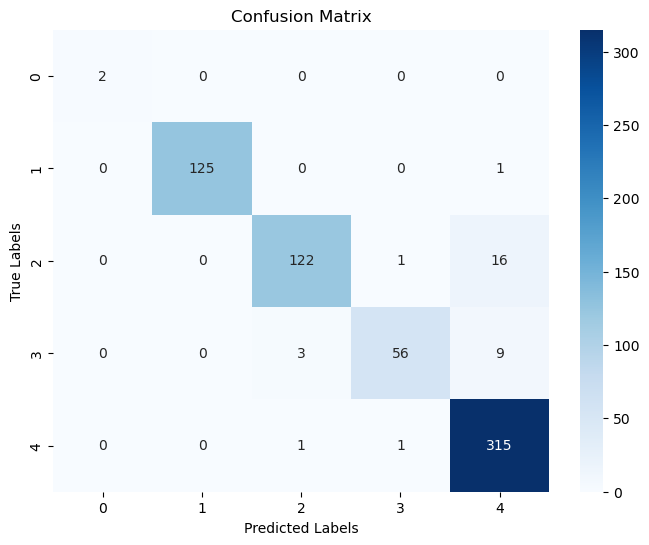

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set
predicted_labels = best_model.predict(test_corpus)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Model Testing
Berikut beberapa sampel judul berita dalam 

In [52]:
test = ('Jeka Saragih On Fire Menatap Debut di UFC')
test_bola =('Onana Dulu Dicaci, Kini Dipuji')
test_Moto_GP =('Update Klasemen MotoGP 2023 - GP Australia Berakhir Tanpa Sprint, Dewi Fortuna Lebih Suka Bagnaia daripada Martin')
test_raket =('French Open 2023: Jonatan Taklukkan Nishimoto')
test_f1 =('Suhu Panas Tak Hentikan Verstappen Menangkan F1 GP Qatar 2023')

In [53]:
line = tfidf_vectorizer.transform([test])
test = clf.predict(line)
test

array(['Olahraga Lainnya'], dtype='<U16')

In [54]:
line = tfidf_vectorizer.transform([test_bola])
test = clf.predict(line)
test

array(['Sepakbola'], dtype='<U16')

In [55]:
line = tfidf_vectorizer.transform([test_Moto_GP])
test = clf.predict(line)
test

array(['Moto GP'], dtype='<U16')

In [56]:
line = tfidf_vectorizer.transform([test_raket])
test = clf.predict(line)
test

array(['Raket'], dtype='<U16')

In [57]:
line = tfidf_vectorizer.transform([test_f1])
test = clf.predict(line)
test

array(['F1'], dtype='<U16')